# llc4320 spectra: Eulerian

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from cmocean import cm
import dask.dataframe as dd
from xhistogram.xarray import histogram

%matplotlib inline
from matplotlib import pyplot as plt
import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.9688006.datarmor0/parcels-502027/libparcels_random_6b2ccbcd-62e1-4573-98e4-f2702f4cbf6c.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=6, processes=12) # necessary?
    w = cluster.scale(jobs=1)
    # 3 needed for lagrangian lon/lat binning
    # 15 for eulerian binning
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.1.71:49471 Dashboard: http://10.148.1.71:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


_________
# Eulerian spectra

__________
# 0. raw spectra (done by AP)

All datasets are in /home/datawork-lops-osi/equinox/mit4320/diags/

30 days windows: spectra_SSUV_T30_nomean.zarr

60 days windows: spectra_SSUV_T60_nomean.zarr

90 days windows: spectra_SSUV_T90_nomean.zarr


In [24]:
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_SSUV_T30_nomean.zarr'))
E

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 720, i: 2160, j: 2160)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(3, 2160, 2160), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(3, 2160, 2160), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(3, 2160, 2160), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.97 -11.93 ... 11.9 11.93 11.97
  * i          (i) int64 0 2 4 6 8 10 12 ... 4306 4308 4310 4312 4314 4316 4318
  * j          (j) int64 0 2 4 6 8 10 12 ... 4306 4308 4310 4312 4314 4316 4318
    mask       (face, j, i) bool dask.array<chunksize=(3, 2160, 2160), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 96, 288, 720), meta=np.ndarray>

---
# 1. lat x lon binning spectra (i.e. 2D spectra, also done by AP)

/home/datawork-lops-osi/equinox/mit4320/diags/spectra_SSUV_T30_nomean_lat_lon.zarr

/home/datawork-lops-osi/equinox/mit4320/diags/spectra_SSUV_T60_nomean_lat_lon.zarr

/home/datawork-lops-osi/equinox/mit4320/diags/spectra_SSUV_T90_nomean_lat_lon.zarr

In [20]:
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_SSUV_T60_nomean_lat_lon.zarr'))
E

<xarray.Dataset>
Dimensions:  (freq_time: 1440, lat_bin: 119, lon_bin: 359)
Coordinates:
  * lat_bin  (lat_bin) float64 -59.5 -58.5 -57.5 -56.5 ... 55.5 56.5 57.5 58.5
  * lon_bin  (lon_bin) float64 -179.5 -178.5 -177.5 -176.5 ... 176.5 177.5 178.5
Dimensions without coordinates: freq_time
Data variables:
    E_SSUV   (freq_time, lon_bin, lat_bin) float64 dask.array<chunksize=(10, 359, 119), meta=np.ndarray>

__________________
# 2. Zonally averaged spectra (i.e.,1D, as a function of lat) 
### This is done by XY

In [8]:
V = ["SSUV"]
T = ["T30_nomean", "T60_nomean", "T90_nomean"]
sub = 2
dl = 1.
lat_bins = np.arange(-60, 60, dl)
    
for v in V:
    for t in T:

        ds = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s.zarr'%(v,t)))
        ds = ds.isel(i=slice(0,None,sub),j=slice(0,None,sub))
        ds = ds.where(ds.Depth>500, drop=False)
        ds['lat3'] = 0*ds.face+ds.YC
        ds['lat4'] = 0*ds[v]+ds.YC
        #ds = ds.persist()
        N = histogram(ds.lat3.rename('lat').where(ds.Depth>500), bins=[lat_bins], 
                      dim=['i', 'j', 'face']
                     ).persist()

        E = histogram(ds.lat4.rename('lat').where(ds.Depth>500), bins=[lat_bins], 
                      weights=ds[v], 
                      dim=['i', 'j', 'face']
                     )

        E = (E/N).rename('E_%s_%s'%(v,t)).persist()
        E = E.rename({'freq_time': 'frequency', 'lat_bin':'lat_bins'})   
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

<SSUV_T30_nomean - allready processed>
<SSUV_T60_nomean - allready processed>
<SSUV_T90_nomean - allready processed>


In [15]:
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_nomean_lat.zarr'))
E

<xarray.Dataset>
Dimensions:            (frequency: 720, lat_bins: 119)
Coordinates:
  * frequency          (frequency) float64 -12.0 -11.97 -11.93 ... 11.93 11.97
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
Data variables:
    E_SSUV_T30_nomean  (frequency, lat_bins) float64 dask.array<chunksize=(720, 119), meta=np.ndarray>

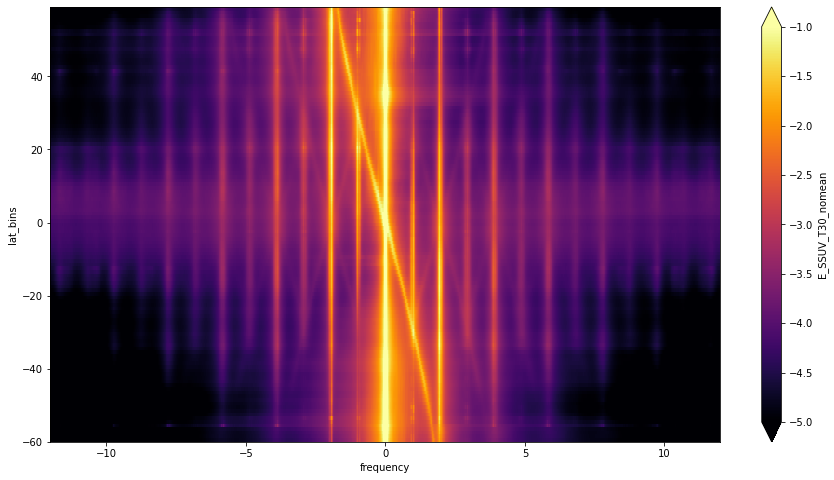

In [7]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_nomean_lat.zarr'))
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV_T30_nomean).plot(x='frequency',vmin=-5,vmax=-1,cmap='inferno')

_____________
# 3. Eulerian 2D KE maps
## lon x lat for band-integrated KE
### From 2D binned spectra (much quicker)
### This is done by XY

In [35]:
# From 2D binned spectra (much quicker)

V = ["SSUV"]
T = ["T30_nomean", "T60_nomean", "T90_nomean"]

dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-60, 60, dl)

bands = {'total': (0., 12), 'low': (0., .5), 'supertidal': (2.4, 12),
         'diurnal_0dot1': (0.9, 1.1), 'diurnal_0dot2': (0.8, 1.2), 'diurnal_0dot3': (0.7, 1.3), 'diurnal_0dot4': (0.6, 1.4),
         'semidiurnal_0dot1': (1.9, 2.1), 'semidiurnal_0dot2': (1.8, 2.2), 'semidiurnal_0dot3': (1.7, 2.3), 'semidiurnal_0dot4': (1.6, 2.4),
         'inertial_0dot1':(0,0),'inertial_0dot2':(0,0),'inertial_0dot3':(0,0),'inertial_0dot4':(0,0)
        }

for v in V:
    for t in T:

        # load 2d binned spectra
        ds_1D = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat.zarr'%(v,t)))
        ds_2D = (xr.open_zarr(os.path.join(ut.root_data_dir,'diags/spectra_%s_%s_lat_lon.zarr'%(v,t)))
                .rename({'lon_bin': 'lon_bins', 'lat_bin': 'lat_bins', 'freq_time': 'frequency'})
             )
        ds = xr.merge([ds_1D, ds_2D])      
        print(ds)
        ds.load()
        # define delta omega, Near-inertial f
        domega = float(ds.frequency[1]- ds.frequency[0])
        f_llc = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(ds['lat_bins']))
        f_cpd_llc = f_llc*86400/2./np.pi
        
 
        # band integral
        Eb = {}
        for b, bounds in bands.items():
            #print('Frequency band {}, frequency bounds: {}-{} cpd'.format(b, bounds[0], bounds[1]))

            if b == "inertial_0dot1":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.1), 
                                  drop=False,
                                )

            elif b == "inertial_0dot2":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.2), 
                                  drop=False,
                                )

            elif b == "inertial_0dot3":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.3), 
                                  drop=False,
                                )                
                
            elif b == "inertial_0dot4":
                _E = ds['E_'+v].where((np.abs(ds.frequency + f_cpd_llc)<=0.4), 
                                  drop=False,
                                )
                
            else:      
                _E = ds['E_'+v].where((np.abs(ds.frequency)>=bounds[0]) & (np.abs(ds.frequency)<=bounds[1]), 
                                  drop=False,
                                )

            E = domega * _E.sum('frequency')    
            Eb[b] = E.persist()

        # converts to single dataset and store:
        E = xr.concat(list(Eb.values()), 
                      dim=pd.Index(list(Eb.keys()),name='frequency_band'),
                     )
        
        E = E.where(E>0)
        
        E.to_dataset().to_zarr(os.path.join(ut.root_data_dir,'diags/%s_%s_lat_lon_bands.zarr'%(v,t)), mode='w')
        print('<%s_%s - allready processed>'%(v,t))        

<xarray.Dataset>
Dimensions:            (frequency: 720, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency          (frequency) float64 -12.0 -11.97 -11.93 ... 11.93 11.97
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins           (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV_T30_nomean  (frequency, lat_bins) float64 dask.array<chunksize=(720, 119), meta=np.ndarray>
    E_SSUV             (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(10, 359, 119), meta=np.ndarray>
<SSUV_T30_nomean - allready processed>
<xarray.Dataset>
Dimensions:            (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
  * lat_bins           (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins           (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV_T60_nomean  (frequency,

In [17]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T30_nomean_lat_lon_bands.zarr'))
E

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(4, 180, 60), meta=np.ndarray>

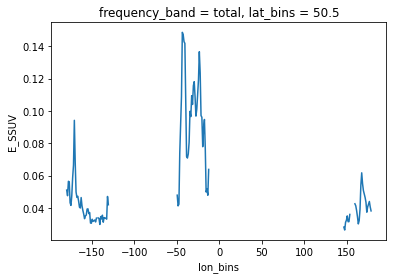

In [18]:
E.E_SSUV.sel(frequency_band='total').isel(lat_bins=110).plot()

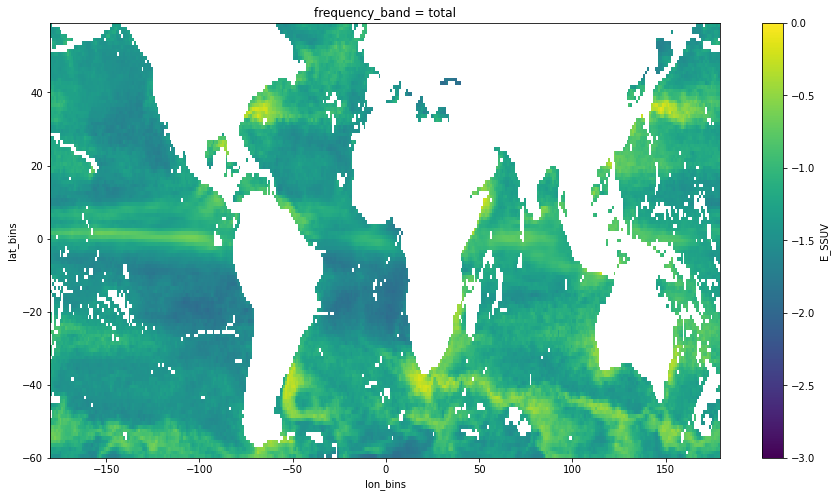

In [19]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='total').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

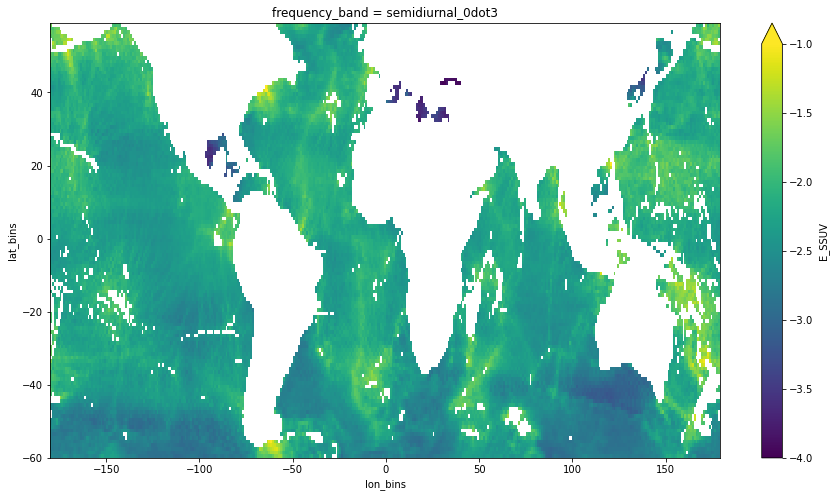

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='semidiurnal_0dot3').plot(x='lon_bins',y='lat_bins',vmin=-4,vmax=-1)

In [9]:
# load
E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T90_nomean_lat_lon_bands.zarr'))
E

<xarray.Dataset>
Dimensions:         (frequency_band: 15, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_SSUV          (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(4, 180, 60), meta=np.ndarray>

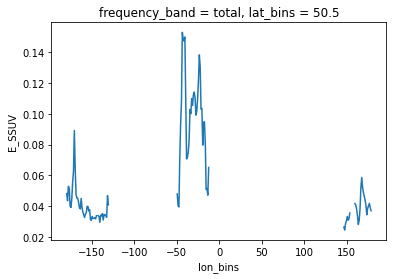

In [11]:
E.E_SSUV.sel(frequency_band='total').isel(lat_bins=110).plot()

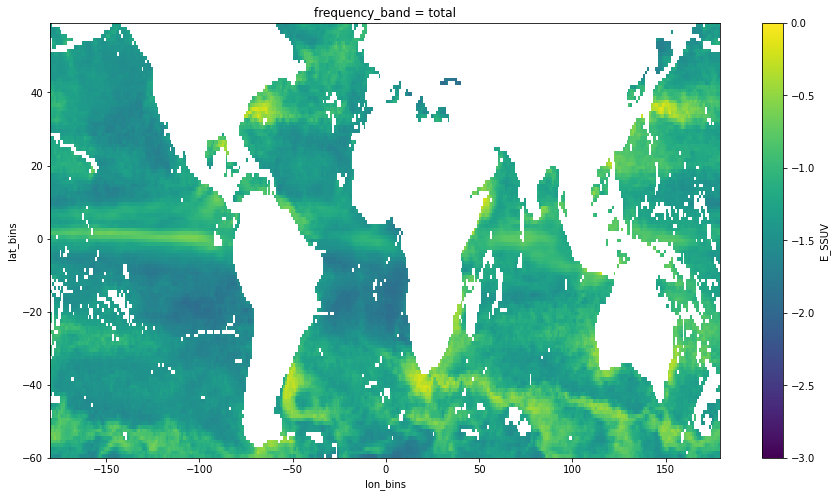

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='total').plot(x='lon_bins',y='lat_bins',vmin=-3,vmax=0)

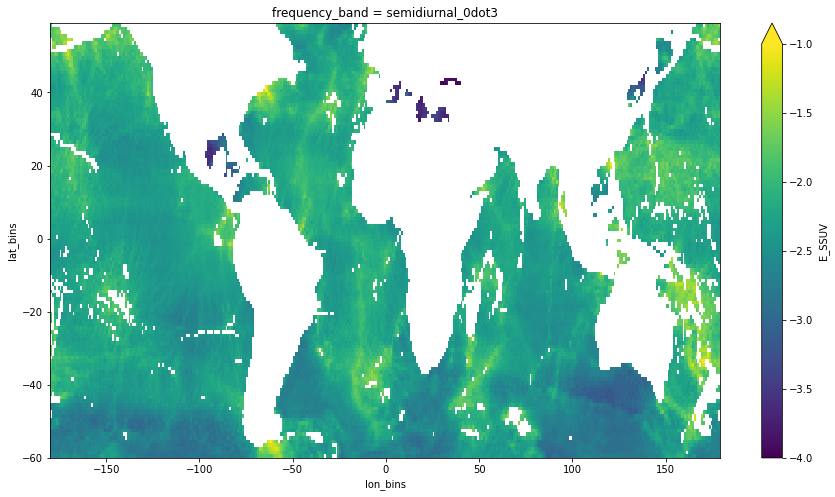

In [16]:
fig, ax = plt.subplots(figsize=(15,8))
ax = plt.subplot(1,1,1)
np.log10(E.E_SSUV).sel(frequency_band='semidiurnal_0dot3').plot(x='lon_bins',y='lat_bins',vmin=-4,vmax=-1)

## Close cluster

In [21]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
